In [6]:
import os
from os import path
import json
import time

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon, Point
from descartes import PolygonPatch
from polylabelfast import polylabelfast
from PIL import Image
# Old version
import polylidar
%matplotlib notebook

sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# os.chdir('../../../')

In [22]:
airsim_colors = [
[55, 181, 57],
[153, 108, 6],
[112, 105, 191],
[89, 121, 72],
# [238, 238, 0], # fake color
[190, 225, 64], # rooftop color
[206, 190, 59],
[81, 13, 36],
[115, 176, 195],
[161, 171, 27],
[135, 169, 180],
[29, 26, 199],
[102, 16, 239],
[242, 107, 146],
[156, 198, 23],
[49, 89, 160],
[68, 218, 116],
[11, 236, 9],
[196, 30, 8],
[121, 67, 28]]
airsim_colors = np.array(airsim_colors) / 255.0

In [59]:
def timeit(method):
    """Simple timing decorator"""
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        ms = (te - ts) * 1000
        return ms, result
    return timed

def tuple_to_list(tuplelist):
    return [list(row) for row in list(tuplelist)]

def get_base_collect_dir(config):
    return config['collect_config']['save_dir']


def get_point(pi, points, is_3D=False):
    if is_3D:
        return [points[pi, 0], points[pi, 1], points[pi, 2]]
    else:
        return [points[pi, 0], points[pi, 1]]

def get_poly_coords(outline, points, is_3D=False):
    return [get_point(pi, points, is_3D) for pi in outline]

def poly_to_rings(poly):
    ext_coord = tuple_to_list(list(poly.exterior.coords))
    holes = [tuple_to_list(ring.coords) for ring in poly.interiors]
    holes.insert(0, ext_coord)
    return holes


def get_lidar_file_name(config, uid):
    base_dir = get_base_collect_dir(config)
    lidar_dir = path.join(base_dir, "Lidar")
    lidar_fname = lidar_dir + '/{}-0.npy'.format(uid)
    lidar_fname = path.realpath(lidar_fname)
    return lidar_fname


def get_polygon_file_name(config, uid, ground_truth):
    base_dir = get_base_collect_dir(config)
    poly_dir = path.join(base_dir, "Polygons")
    suffix = "groundtruth" if ground_truth else "predicted"
    poly_fname = poly_dir + '/{}-0-{}.geojson'.format(uid, suffix)
    poly_fname = path.realpath(poly_fname)
    return poly_fname


def get_classified_lidar_file_name(config, uid, ground_truth):
    base_dir = get_base_collect_dir(config)
    lidar_dir = path.join(base_dir, "LidarClassified")
    suffix = "groundtruth" if ground_truth else "predicted"
    lidar_fname = lidar_dir + '/{}-0-{}.npy'.format(uid, suffix)
    lidar_fname = path.realpath(lidar_fname)
    return lidar_fname


def get_img_file_name(config, uid, img_type='Segmentation', ground_truth=None):
    base_dir = get_base_collect_dir(config)
    if ground_truth is None:
        fname = "{}-0.png".format(uid)
    else:
        suffix = "groundtruth" if ground_truth else "predicted"
        fname = "{}-0-{}.png".format(uid, suffix)
    img_fname = path.join(base_dir, img_type, fname)
    return img_fname


def load_image(config, uid, img_type='Segmentation'):
    """Loads an image as a numpy array from a file"""
    img_fpath = get_img_file_name(config, uid, img_type)
    img = Image.open(img_fpath)
    return np.array(img)


def load_point_cloud(config, uid, classified=False, ground_truth=False):
    """Loads a point cloud from a file"""
    if classified:
        lidar_fname = get_classified_lidar_file_name(config, uid, ground_truth)
    else:
        lidar_fname = get_lidar_file_name(config, uid)
    point_cloud = np.load(lidar_fname)
    return point_cloud

def scale_points(points, z_value=None, reverse=False, reverse_y=False):
    new_y = - points[:, 1] if reverse_y else points[:, 1]
        
    if z_value is not None:
        return points[:,0], new_y, np.ones_like(points[:, 1]) * z_value
    elif reverse:
        return points[:,0], new_y, -points[:,2]
    else:
        return points[:,0], new_y, points[:,2]

    
def plot_polygon(polygon, ax, shell_color='green', hole_color='orange'):
    outline = Polygon(shell=polygon.exterior.coords)
    outlinePatch = PolygonPatch(outline, ec=shell_color, fill=False, linewidth=2)
    ax.add_patch(outlinePatch)

    for hole_poly in polygon.interiors:
        outline = Polygon(shell=hole_poly)
        outlinePatch = PolygonPatch(outline, ec=hole_color, fill=False, linewidth=2)
        ax.add_patch(outlinePatch)

def load_polygon(config, uid, ground_truth=False):
    """Attempts to load a polygon geojson file"""
    poly_fpath = get_polygon_file_name(config, uid, ground_truth)
    try:
        with open(poly_fpath) as f:
            poly_geojson = json.load(f)
        # print(poly_geojson)
        poly = shape(poly_geojson['geometry'])
        # print(poly)
        return poly, poly_geojson['properties']['height']
    except Exception as e:
        return None, None
    

@timeit
def timed_polylabel(poly_rings, precision=0.5):
    return polylabelfast(poly_rings, precision)


def get_best_polygon(polygons, points, building_name, uid):
    """Converts a list of C++ polygon to shapely polygon
    If more than one polygon is returned from polylidar, selects the one with the largest shell
    """
    polygons.sort(key=lambda poly: len(poly.shell), reverse=True)
    if not polygons:
        logging.warn("No polygons returned for uid: %r; building: %r", uid, building_name)
        return None
    if len(polygons) > 1:
        logging.debug("More than one polygon at building %r", building_name)
    poly = polygons[0]
    shell_coords = get_poly_coords(poly.shell, points)
    hold_coords = [get_poly_coords(hole, points) for hole in poly.holes]
    poly_shape = Polygon(shell=shell_coords, holes=hold_coords)
    return poly_shape


def extract_largest_circle(poly, buffer=-0.0, precision=0.5):
    poly = poly.buffer(buffer)
    poly = poly.simplify(abs(buffer))
    if poly.type == 'MultiPolygon':
        polys = [geom for geom in poly.geoms]
        polys = sorted(polys, lambda poly_: poly_.area, reverse=True)
        poly = polys[0]
    poly_list = poly_to_rings(poly)
    # print(poly_list)
    return timed_polylabel(poly_list, precision)    

def create_cmap(cmap_list):
    number_of_classes = len(cmap_list)
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Unreal', cmap_list, number_of_classes)
    # define the bins and normalize
    bounds = np.linspace(0,number_of_classes,number_of_classes+1)
    norm = mpl.colors.BoundaryNorm(bounds, number_of_classes)
    return cmap, norm

def map_colors(values, cmap, norm):
    return cmap(norm(values))

def fake_building():
    NUM_PLANE_POINTS = 200
    NOISE = 0.1
    xy = np.random.uniform(0, 10, (NUM_PLANE_POINTS,2))
    z = np.random.uniform(10, 10 + NOISE, NUM_PLANE_POINTS)
    cRoof = np.ones(NUM_PLANE_POINTS) * 4
    lidar_roof = np.column_stack((xy, z, cRoof))

    xy = np.random.uniform(2, 5, (10,2))
    z = np.ones(10) * 10
    cTarp = np.ones(10) * 17
    lidar_tarp = np.column_stack((xy, z, cTarp))

    lidar_roof.shape
    lidar_building = np.concatenate((lidar_roof, lidar_tarp), axis=0)
    point_colors = map_colors(lidar_building[:, 3], cmap, norm)
    return lidar_building, point_colors

def fake_building(base_size=10):
    NUM_PLANE_POINTS = 200
    NOISE = 0.1
    np.linspace(0, base_size, base_size)
    xy = np.random.uniform(0, 10, (NUM_PLANE_POINTS,2))
    z = np.random.uniform(10, 10 + NOISE, NUM_PLANE_POINTS)
    cRoof = np.ones(NUM_PLANE_POINTS) * 4
    lidar_roof = np.column_stack((xy, z, cRoof))

    xy = np.random.uniform(2, 5, (10,2))
    z = np.ones(10) * 10
    cTarp = np.ones(10) * 17
    lidar_tarp = np.column_stack((xy, z, cTarp))

    lidar_roof.shape
    lidar_building = np.concatenate((lidar_roof, lidar_tarp), axis=0)
    point_colors = map_colors(lidar_building[:, 3], cmap, norm)
    return lidar_building, point_colors


def fake_building_simple(x_dim=[0, 10, 1], y_dim=[0,10, 1], avg_height=10.0, obstacle_class_postion=[2, 4], obstacle_height_postion=[6, 9], seed=1, roof_color=4):
    
    np.random.seed(seed)
    x = np.arange(*x_dim)
    y = np.arange(*y_dim)
    
    size_x_diff = x.shape[0]
    size_y_diff = y.shape[0]

    x, y = np.meshgrid(x,y)
    z = np.ones_like(x) * avg_height
    c = np.ones_like(x) * roof_color

    ## add tarp (different class)
    if obstacle_class_postion is not None:
        low = obstacle_class_postion[0]; high = obstacle_class_postion[1]
        c[low:high, low:high] = 17
    
    ## add height obstacle
    if obstacle_height_postion is not None:
        low = obstacle_height_postion[0]; high = obstacle_height_postion[1]
        z[low:high, low] = avg_height + 1.0
        z[low:high, low + 1] = avg_height + 3.0
        z[low:high, low +2] = avg_height + 1.0
        c[low:high, low] = 16
        c[low:high, low + 1] = 16
        c[low:high, low +2] = 16

    x = x.flatten()
    y = y.flatten()
    z = z.flatten()
    c = c.flatten()
    

    lidar_data = np.column_stack((x, y, z))
    lidar_data = lidar_data + np.random.multivariate_normal(np.ones(3) * 0, np.eye(3) * .01, size_x_diff * size_y_diff)
    lidar_data = np.column_stack((lidar_data, c))
    point_colors = map_colors(c, cmap, norm)
    return lidar_data, point_colors

def plot_planes(triangles, planes, ax):
    for plane in planes:
        triangles_plane = triangles[plane]
        ax.plot_trisurf(*scale_points(lidar_building),triangles=triangles_plane,  edgecolor='k', linewidth=0.5)
        

def plot_polylidar_example(lidar_building, traingles, planes):
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8),
                           subplot_kw=dict(projection='3d'))
    ax.plot_trisurf(*scale_points(lidar_building, z_value=0.0),triangles=triangles, color=(1, 0, 0, 0.0), edgecolor='k', linewidth=0.5)
    plot_planes(triangles, planes, ax)
    ax.scatter(*scale_points(lidar_building), c=point_colors, zorder=10, edgecolors='k', s=40)
    # ax.scatter(*scale_points(lidar_building, z_value=0.0), c=point_colors)
    ax.set_zlim3d(0,15)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    return fig

def plot_bbox_fake(X, Y, Z, ax):
    # Create cubic bounding box to simulate equal aspect ratio
    max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
    Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
    Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
    Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()+Z.min())
    # Comment or uncomment following both lines to test the fake bounding box:
    for xb, yb, zb in zip(Xb, Yb, Zb):
       ax.plot([xb], [yb], [zb], 'w')
    

def plot_polylabel_example(polygon, point, radius, star_color='blue'):
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    circle = Point(*point).buffer(radius)
    plot_polygon(polygon, ax)
    plot_polygon(circle, ax, shell_color='blue')
    ax.scatter(point[0], point[1], marker='*', color=star_color, s=40)
    ax.axis('equal')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    return fig

palette = sns.color_palette()
cmap, norm = create_cmap(airsim_colors)
map_colors(17, cmap, norm)

(0.7686274509803922, 0.11764705882352944, 0.03137254901960784, 1.0)

In [61]:
with open("./assets/rooftop/scripts/config_gather_stats.json") as f:
    config = json.load(f)
    # Load collector config file
    collector_config_fname = config['collect_config']
    with open(collector_config_fname) as f:
        collect_config = json.load(f)

    # load geojson information
    config['collect_config'] = collect_config


stat_records_fname = "AirSimCollectData/LidarRoofManualTest/stat_records.json"
with open(stat_records_fname) as f:
    stat_records = json.load(f)
df = pd.DataFrame.from_dict(stat_records)

uid = 55
lidar_building_gt = load_point_cloud(config, uid, classified=True, ground_truth=True)
lidar_building_gt = lidar_building_gt[lidar_building_gt[:, 2] < 7]
lidar_building_gt[:, 0], lidar_building_gt[:, 1], lidar_building_gt[:, 2]  = scale_points(lidar_building_gt[lidar_building_gt[:, 2] < 7], reverse=True, reverse_y=True)
lidar_building_pr = load_point_cloud(config, uid, classified=True, ground_truth=False)

<IPython.core.display.Javascript object>


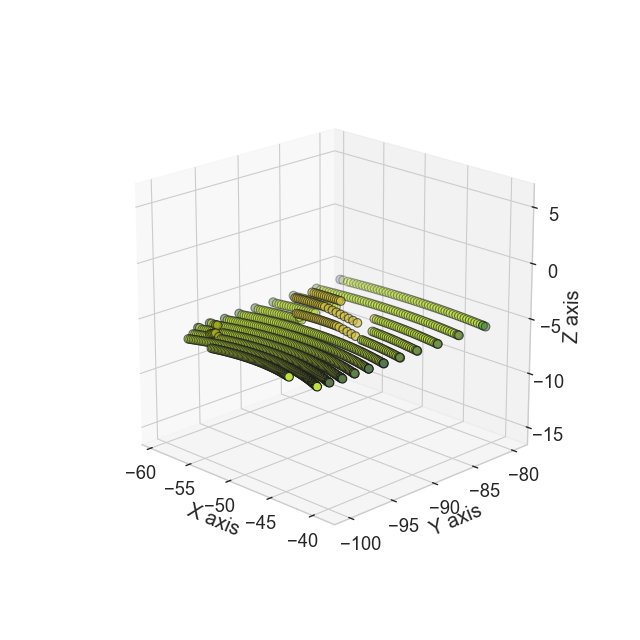

In [70]:
point_colors = map_colors(lidar_building_gt[:, 3], cmap, norm)
sns.set_style("whitegrid")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8),
                       subplot_kw=dict(projection='3d'))
ax.set_aspect('equal')
plot_bbox_fake(*scale_points(lidar_building_gt), ax)
ax.scatter(*scale_points(lidar_building_gt), c=point_colors, zorder=10, edgecolors='k', s=60)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.view_init(azim=-45,elev=20)
fig.savefig("assets/rooftop/notebooks/imgs/pc_ls_example_classified.png", bbox_inches="tight")

<IPython.core.display.Javascript object>


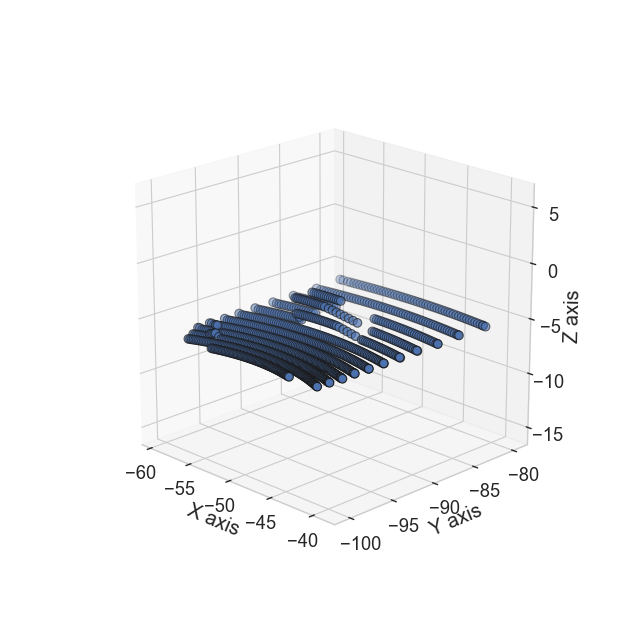

In [71]:
point_colors = map_colors(lidar_building_gt[:, 3], cmap, norm)
sns.set_style("whitegrid")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8),
                       subplot_kw=dict(projection='3d'))
ax.set_aspect('equal')
plot_bbox_fake(*scale_points(lidar_building_gt), ax)
ax.scatter(*scale_points(lidar_building_gt), zorder=10, edgecolors='k', s=60)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.view_init(azim=-45,elev=20)
fig.savefig("assets/rooftop/notebooks/imgs/pc_ls_example_unclassified.png", bbox_inches="tight")

<IPython.core.display.Javascript object>


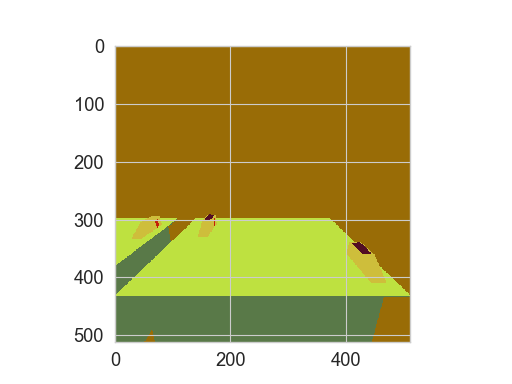

In [22]:
img = load_image(config, uid, "Segmentation")
plt.imshow(img)

<IPython.core.display.Javascript object>


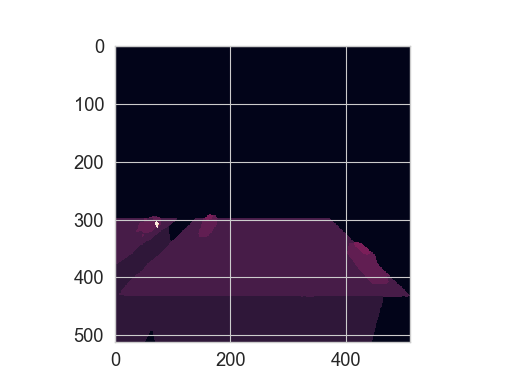

In [23]:
img = load_image(config, uid, "SegmentationPredicted")
plt.imshow(img)